# Create, evaluate, and score an Uplift model

## Introduction

This notebook demonstrates the data science work flow with an end-to-end example. The notebook creates, trains, and evaluates an uplift model that refers to a collection of machine learning techniques. These techniques are used to estimate the incremental effects of a treatment on the behavior of an individual or a sub-group. 

This notebook covers these topics:

1. Load the data
2. Understand and process the data through exploratory data analysis
3. Train a machine learning model with an uplift model
4. Save the final machine learning model
5. Load the machine learning model for scoring and making predictions

## Prerequisites

- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will download data from a public blob, then store the data in the lakehouse resource.

### What is Uplift Modeling?

Uplift modeling relies on a set of causal inference techniques that utilize machine learning models to identify the most suitable treatment, from a group of possible treatments, that leads to the most desirable outcome. Study of both a treatment group - individuals who undergo a treatment - and a control group - individuals who do not undergo that treatment - determines outcome desirability. This approach classifies individuals into four main subgroups within a population:

- **Persuadables**: This group of individuals will respond positively only when given the treatment.
- **Sleeping-dogs**: This group of individuals will show a strong negative response to the treatment.
- **Lost Causes**: This group of individuals will never achieve the desired outcome, even with the treatment.
- **Sure Things**: This group of individuals will achieve the outcome regardless of whether they receive the treatment or not.

For its primary objective, uplift modeling identifies the **"persuadables"**, since a focus on them can lead to a more favorable outcome. Conversely, efforts directed toward the **"lost causes"** and **"sure things"** groups would become ineffective, and the **"sleeping dogs"** group could potentially result in negative outcomes. Uplift modeling finds practical applications in various fields

- marketing
- healthcare
- social sciences
- etc.

where it optimizes decision-making and it enhances the effectiveness of interventions.

### How does Uplift modeling work?

The main techniques used for uplift modeling include:

- Meta Learner, to predict the difference between an individual's behavior when the individual undergoes a treatment, and when not undergoing a treatment.

- Uplift Tree, a tree-based algorithm that combines both treatment/control group assignment information and response information directly into decisions about splitting criterion for a node.

- Neural Network-based Model, which usually works with observational data. It uses deep learning to help determine the distribution of a latent variable. The latent variable represents the co-founder in the uplift modeling.

### What benefits does Uplift modeling offer?

- For marketing applications, uplift modeling can help identify persuadables who can potentially be swayed to try the treatment. The outreach to identify persuadables could involve a coupon or an online advertisement, for example.
- For medical treatments, uplift modeling can help measure how a particular treatment can impact distinct groups. This allows for optimized target selection, to maximize the impact.


## Step 1: Load the Data

#### Dataset

The Criteo AI Lab created the dataset. That dataset has 13M rows. Each row represents one user. Each row has twelve features, a treatment indicator, and two binary labels that include visit and conversion.

|f0|f1|f2|f3|f4|f5|f6|f7|f8|f9|f10|f11|treatment|conversion|visit|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

- **f0 - f11**: feature values (dense, floating values)
- **treatment**: whether or not a user was randomly targeted for treatment (e.g., advertising) (1 = treatment, 0 = control)
- **conversion**: whether a conversion occurred (e.g., made a purchase) for a user (binary, label)
- **visit**: whether a visit occurred (e.g., visit the online store) for a user (binary, label)

#### Citation

- Dataset homepage: https://ailab.criteo.com/criteo-uplift-prediction-dataset/

The dataset used for this notebook requires this BibTex citation:

    @inproceedings{Diemert2018,
    author = {{Diemert Eustache, Betlei Artem} and Renaudin, Christophe and Massih-Reza, Amini},
    title={A Large Scale Benchmark for Uplift Modeling},
    publisher = {ACM},
    booktitle = {Proceedings of the AdKDD and TargetAd Workshop, KDD, London,United Kingdom, August, 20, 2018},
    year = {2018}
    }

> [!TIP]
> By defining the following parameters, you can apply this notebook on different datasets easily.

In [1]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually by user
DATA_FOLDER = "Files/uplift-modelling"
DATA_FILE = "criteo-research-uplift-v2.1.csv"

FEATURE_COLUMNS = [f"f{i}" for i in range(12)]
TREATMENT_COLUMN = "treatment"
LABEL_COLUMN = "visit"

EXPERIMENT_NAME = "aisample-upliftmodelling"  # MLflow experiment name

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 3, Finished, Available)

#### Import Libraries

Before processing, you must import required Spark and SynapseML libraries. You must also import a data visualization library - for example, Seaborn, a Python data visualization library. A data visualization library provides a high-level interface to build visual resources on DataFrames and arrays. Learn more about [Spark](https://spark.apache.org/), [SynapseML](https://aka.ms/AboutSynapseML) and [Seaborn](https://seaborn.pydata.org/).

In [2]:
import os
import gzip

import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

%matplotlib inline

from synapse.ml.featurize import Featurize
from synapse.ml.core.spark import FluentAPI
from synapse.ml.lightgbm import *
from synapse.ml.train import ComputeModelStatistics

import mlflow

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 4, Finished, Available)

#### Download dataset and upload to lakehouse

This code downloads a publicly available version of the dataset, and then stores that data resource in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [3]:
if not IS_CUSTOM_DATA:
    # Download demo data files into lakehouse if not exist
    import os, requests

    remote_url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
    download_file = "criteo-research-uplift-v2.1.csv.gz"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{DATA_FILE}"):
        r = requests.get(f"{remote_url}", timeout=30)
        with open(f"{download_path}/{download_file}", "wb") as f:
            f.write(r.content)
        with gzip.open(f"{download_path}/{download_file}", "rb") as fin:
            with open(f"{download_path}/{DATA_FILE}", "wb") as fout:
                fout.write(fin.read())
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 5, Finished, Available)

Downloaded demo data files into lakehouse.


Start recording the runtime of this notebook.

In [4]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 6, Finished, Available)

#### Set up the MLflow experiment tracking

To extend the MLflow logging capabilities, autologging automatically captures the values of input parameters and output metrics of a machine learning model during its training. This information is then logged to the workspace, where the MLflow APIs or the corresponding experiment in the workspace can access and visualize it. Visit [this resource](https://aka.ms/fabric-autologging) for more information about autologging.

In [5]:
# Set up the MLflow experiment
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 7, Finished, Available)

To disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()`, and set `disable=True`

#### Read data from the lakehouse

Read raw data from the lakehouse **Files** section and add additional columns for different date parts. The same information will be used to create a partitioned delta table.

In [6]:
raw_df = spark.read.csv(f"{DATA_FOLDER}/raw/{DATA_FILE}", header=True, inferSchema=True).cache()

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 8, Finished, Available)

## Step 2: Exploratory Data Analysis

Use the `display` command to view high-level statistics about the dataset. You can also show the Chart views to easily visualize subsets of the dataset.

In [7]:
display(raw_df.limit(20))

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4b4c30fd-819e-47ac-b5b4-8bbc70921bbc)

Examine the percentage of the users that visit, the percentage of users that convert, and the percentage of the visitors that convert.

In [8]:
raw_df.select(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()


StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 10, Finished, Available)

+------------------------------+--------------------------------+-----------------------------------+
|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+------------------------------+--------------------------------+-----------------------------------+
|          0.046992000911042324|            0.002916680257907384|                0.06206759025709019|
+------------------------------+--------------------------------+-----------------------------------+



This analysis indicates that **4.7%** of all users visited the online store. Only **0.29%** converted (e.g., made a purchase). This means that the conversion rate of visitors is **6.2%**.

Additionally, examine the overall average treatment effect on visits and conversions. A treatment of 1 indicates the user was offered or exposed to advertising (e.g., discount coupons, gifts, or other privileges). A treatment of 0 indicates that the user was not offered or exposed to any form of advertising.

In [9]:
raw_df.groupby("treatment").agg(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()


StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 11, Finished, Available)

+---------+------------------------------+--------------------------------+-----------------------------------+
|treatment|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+---------+------------------------------+--------------------------------+-----------------------------------+
|        1|          0.048543360048743316|            0.003089461067412...|                0.06364332968115058|
|        0|           0.03820095691954503|            0.001937588015281...|                0.05072092878097497|
+---------+------------------------------+--------------------------------+-----------------------------------+



The analysis indicates that **4.9%** of users from the treatment group - users that received the treatment, or advertising - visited the online store. Only **3.8%** of users from the control group - users that did not receive the treatment, or were not offered or exposed to advertising - did the same. Additionally, **0.31%** of all users from the treatment group converted, or made a purchase - while only **0.19%** of users from the control group did so. As a result, the conversion rate of visitors that made a purchase, who were also members of treatment group, is **6.36%**, compared to only **5.07%** for users of the control group. This means that the treatment can potentially improve the visit rate by about **1%**, and the conversion rate of visitors by about **1.3%**. This is a significant improvement.

## Step 3: Define the Model for Training

#### Prepare the training and test datasets

You'll fit a Featurize transformer to the `raw_df` DataFrame, to extract features from the specified input columns and output those features to a new column named `features`.

The resulting DataFrame is stored in a new DataFrame named `df`.

In [10]:
transformer = Featurize().setOutputCol("features").setInputCols(FEATURE_COLUMNS).fit(raw_df)
df = transformer.transform(raw_df)

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 12, Finished, Available)

In [11]:
# Split the DataFrame into training and test sets, with a 80/20 ratio and a seed of 42
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Print the training and test dataset sizes
print("Size of train dataset: %d" % train_df.count())
print("Size of test dataset: %d" % test_df.count())

# Group the training dataset by the treatment column, and count the number of occurrences of each value
train_df.groupby(TREATMENT_COLUMN).count().show()

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 13, Finished, Available)

Size of train dataset: 11182965
Size of test dataset: 2796627
+---------+-------+
|treatment|  count|
+---------+-------+
|        1|9505415|
|        0|1677550|
+---------+-------+



#### Prepare treatment and control datasets

After you create the training and test datasets, you must also form the treatment and control datasets, to train the machine learning models to measure the uplift.

In [12]:
# Extract the treatment and control DataFrames
treatment_train_df = train_df.where(f"{TREATMENT_COLUMN} > 0")
control_train_df = train_df.where(f"{TREATMENT_COLUMN} = 0")

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 14, Finished, Available)

Now that you prepared your data, you can proceed to train a model with LightGBM.

#### Uplift Modeling: T-Learner with LightGBM

Meta-learners are a set of algorithms, built on top of machine learning algorithms like LightGBM, Xgboost, etc. They help estimate conditional average treatment effect, or **CATE**.
T-learner is a meta-learner that doesn't use a single model. Instead, T-learner uses one model per treatment variable. Therefore, two models are developed and hence it is referred to as T-learner. T-learner uses multiple machine learning models to overcome the problem of entirely discarding the treatment, by forcing the learner to first split on it.

In [13]:
mlflow.autolog(exclusive=False)

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 15, Finished, Available)

2023/09/08 23:21:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/09/08 23:21:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [14]:
classifier = (
    LightGBMClassifier()
    .setFeaturesCol("features")  # Set the column name for features
    .setNumLeaves(10)  # Set the number of leaves in each decision tree
    .setNumIterations(100)  # Set the number of boosting iterations
    .setObjective("binary")  # Set the objective function for binary classification
    .setLabelCol(LABEL_COLUMN)  # Set the column name for the label
)

# Start a new MLflow run with the name "uplift"
active_run = mlflow.start_run(run_name="uplift")

# Start a new nested MLflow run with the name "treatment"
with mlflow.start_run(run_name="treatment", nested=True) as treatment_run:
    treatment_run_id = treatment_run.info.run_id  # Get the ID of the treatment run
    treatment_model = classifier.fit(treatment_train_df)  # Fit the classifier on the treatment training data

# Start a new nested MLflow run with the name "control"
with mlflow.start_run(run_name="control", nested=True) as control_run:
    control_run_id = control_run.info.run_id  # Get the ID of the control run
    control_model = classifier.fit(control_train_df)  # Fit the classifier on the control training data

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 16, Finished, Available)

2023/09/08 23:22:18 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('features', VectorUDT(), True)]. Model signature is not logged.
2023/09/08 23:22:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpack5q2cd/model, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to DEBUG to see the full traceback.
2023/09/08 23:22:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/09/08 23:22:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpuocncyyt/model, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to DEBUG to see the full traceback.


#### Predict using the test dataset

Here, you use the `treatment_model` and `control_model`, both defined earlier, to transform the `test_df` test dataset. Then, you'll calculate the predicted uplift. You'll define the predicted uplift as the difference between the predicted treatment outcome and the predicted control outcome. The greater this predicted uplift difference, the greater the effectiveness of the treatment (e.g., advertising) on an individual or a sub-group.


In [15]:
getPred = F.udf(lambda v: float(v[1]), FloatType())

# Cache the resulting DataFrame for easier access
test_pred_df = (
    test_df.mlTransform(treatment_model)
    .withColumn("treatment_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .mlTransform(control_model)
    .withColumn("control_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .withColumn("pred_uplift", F.col("treatment_pred") - F.col("control_pred"))
    .select(TREATMENT_COLUMN, LABEL_COLUMN, "treatment_pred", "control_pred", "pred_uplift")
    .cache()
)

# Display the first twenty rows of the resulting DataFrame
display(test_pred_df.limit(20))

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2b05e279-7816-43b3-857c-cb58b1bb8f4d)

#### Perform Model Evaluation

Since actual uplift cannot be observed for each individual, you need to measure the uplift over a group of individuals. You'll use an Uplift Curve that plots the real, cumulative uplift across the population.

![criteo_uplift_curve.jpeg](https://mmlspark.blob.core.windows.net/graphics/notebooks/criteo_uplift_curve.jpeg)

The x-axis represents the ratio of the population selected for the treatment. A value of 0 suggests no treatment group - no one is exposed to, or offered, the treatment. A value of 1 suggests a full treatment group - everyone is exposed to, or offered, the treatment. The y-axis shows the uplift measure. The aim is to find the size of the treatment group, or the percentage of the population that would be offered or exposed to the treatment (e.g., advertising). This optimizes the target selection, to maximize its impact.

First, rank the test DataFrame order by the predicted uplift. The predicted uplift is the difference between the predicted treatment outcome and the predicted control outcome.

In [16]:
# Compute the percentage rank of the predicted uplift values in descending order, and display the top twenty rows
test_ranked_df = test_pred_df.withColumn("percent_rank", F.percent_rank().over(Window.orderBy(F.desc("pred_uplift"))))

display(test_ranked_df.limit(20))

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, e9b3eb0d-ff8b-4654-b0d8-c62ab740be69)

Next, calculate the cumulative percentage of visits in both the treatment and control groups.

In [17]:
# Calculate the number of control and treatment samples
C = test_ranked_df.where(f"{TREATMENT_COLUMN} == 0").count()
T = test_ranked_df.where(f"{TREATMENT_COLUMN} != 0").count()

# Add columns to the DataFrame to calculate the control and treatment cumulative sum
test_ranked_df = (
    test_ranked_df.withColumn(
        "control_label",
        F.when(F.col(TREATMENT_COLUMN) == 0, F.col(LABEL_COLUMN)).otherwise(0),
    )
    .withColumn(
        "treatment_label",
        F.when(F.col(TREATMENT_COLUMN) != 0, F.col(LABEL_COLUMN)).otherwise(0),
    )
    .withColumn(
        "control_cumsum",
        F.sum("control_label").over(Window.orderBy("percent_rank")) / C,
    )
    .withColumn(
        "treatment_cumsum",
        F.sum("treatment_label").over(Window.orderBy("percent_rank")) / T,
    )
)

# Display the first 20 rows of the dataframe
display(test_ranked_df.limit(20))

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, ad5b29a3-0feb-4bd7-a223-a7aeb494bf08)

Finally, at each percentage, calculate the uplift of the group as the difference between the cumulative percentage of visits between the treatment and control groups.

In [18]:
test_ranked_df = test_ranked_df.withColumn("group_uplift", F.col("treatment_cumsum") - F.col("control_cumsum")).cache()
display(test_ranked_df.limit(20))

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 20, Finished, Available)

SynapseWidget(Synapse.DataFrame, ace1f9a9-9e27-41a3-829e-75f6320315c3)

Now, plot the uplift curve for the test dataset prediction. Note that you must convert the PySpark DataFrame to a Pandas DataFrame before plotting.

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 21, Finished, Available)

/tmp/ipykernel_10137/3726734023.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which="major")


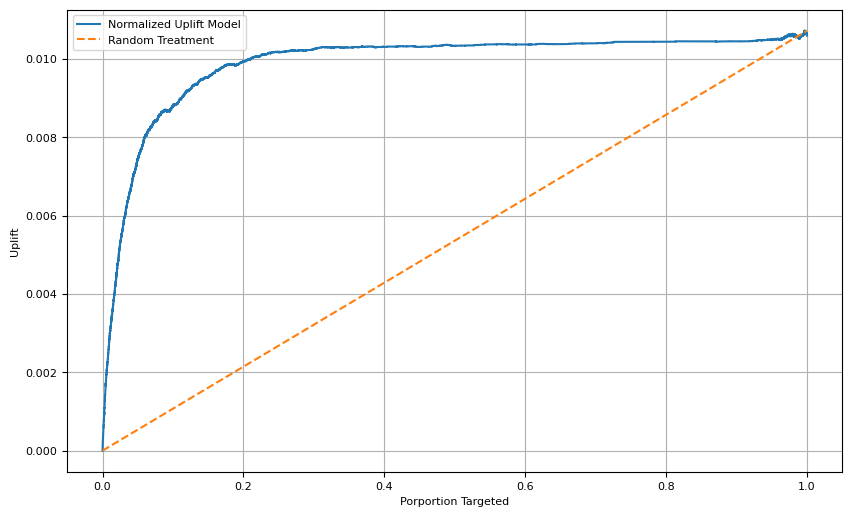

In [19]:
def uplift_plot(uplift_df):
    """
    Plot the uplift curve
    """
    gain_x = uplift_df.percent_rank
    gain_y = uplift_df.group_uplift
    # Plot the data
    fig = plt.figure(figsize=(10, 6))
    mpl.rcParams["font.size"] = 8

    ax = plt.plot(gain_x, gain_y, color="#2077B4", label="Normalized Uplift Model")

    plt.plot(
        [0, gain_x.max()],
        [0, gain_y.max()],
        "--",
        color="tab:orange",
        label="Random Treatment",
    )
    plt.legend()
    plt.xlabel("Porportion Targeted")
    plt.ylabel("Uplift")
    plt.grid(b=True, which="major")

    return fig, ax


test_ranked_pd_df = test_ranked_df.select(["pred_uplift", "percent_rank", "group_uplift"]).toPandas()
fig, ax = uplift_plot(test_ranked_pd_df)

mlflow.log_figure(fig, "UpliftCurve.png")


This analysis and the uplift curve both show that the top 20% population, as ranked by the prediction, would have a large gain if they received the treatment. This means that the top 20% of the population represents the **persuadables** group. Therefore, you can then set the cutoff score for the desired size of treatment group at 20%, to identify the target selection customers for the greatest impact.

In [20]:
cutoff_percentage = 0.2
cutoff_score = test_ranked_pd_df.iloc[int(len(test_ranked_pd_df) * cutoff_percentage)][
    "pred_uplift"
]

print("Uplift scores that exceed {:.4f} map to Persuadables.".format(cutoff_score))
mlflow.log_metrics(
    {"cutoff_score": cutoff_score, "cutoff_percentage": cutoff_percentage}
)

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 22, Finished, Available)

Uplift scores that exceed 0.0039 map to Persuadables.


## Step 4: Register the final ML Model

You'll use MLflow to track and log all experiments for both treatment and control groups. This tracking and logging includes the corresponding parameters, metrics, and the models. Note that this information is logged under the experiment name, in the workspace, for later use.

In [21]:
# Register the model
treatment_model_uri = "runs:/{}/model".format(treatment_run_id)
mlflow.register_model(treatment_model_uri, f"{EXPERIMENT_NAME}-treatmentmodel")

control_model_uri = "runs:/{}/model".format(control_run_id)
mlflow.register_model(control_model_uri, f"{EXPERIMENT_NAME}-controlmodel")

mlflow.end_run()

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 23, Finished, Available)

Successfully registered model 'aisample-upliftmodelling-treatmentmodel'.
2023/09/08 23:24:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-upliftmodelling-treatmentmodel, version 7
Created version '7' of model 'aisample-upliftmodelling-treatmentmodel'.
Successfully registered model 'aisample-upliftmodelling-controlmodel'.
2023/09/08 23:24:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-upliftmodelling-controlmodel, version 7
Created version '7' of model 'aisample-upliftmodelling-controlmodel'.


To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case _aisample-upliftmodelling_.


<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Uplift-experiment.png"  width="75%" height="30%">


## Step 5: Save Prediction Results

Microsoft Fabric offers PREDICT - a scalable function that supports batch scoring in any compute engine. It enables customers to operationalize machine learning models. Users can create batch predictions straight from a notebook or the item page for a specific model. Visit [this](https://aka.ms/fabric-predict) resource to learn more about PREDICT, and to learn how to use PREDICT in Microsoft Fabric.

In [22]:
# Load the model back
loaded_treatmentmodel = mlflow.spark.load_model(treatment_model_uri, dfs_tmpdir="Files/spark")
loaded_controlmodel = mlflow.spark.load_model(control_model_uri, dfs_tmpdir="Files/spark")

# Make predictions
batch_predictions_treatment = loaded_treatmentmodel.transform(test_df)
batch_predictions_control = loaded_controlmodel.transform(test_df)
batch_predictions_treatment.show(5)


StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 24, Finished, Available)

2023/09/08 23:24:04 INFO mlflow.spark: 'runs:/0f031ba3-ab05-4f08-8607-78cbd5e05767/model' resolved as 'sds://lake.trident.com/bf0c4a18-5045-40be-a890-7e904b6be261/6a40b6fe-f756-4db8-ba35-11494ad4abab/0f031ba3-ab05-4f08-8607-78cbd5e05767/artifacts/model'
2023/09/08 23:24:05 INFO mlflow.spark: File 'sds://lake.trident.com/bf0c4a18-5045-40be-a890-7e904b6be261/6a40b6fe-f756-4db8-ba35-11494ad4abab/0f031ba3-ab05-4f08-8607-78cbd5e05767/artifacts/model/sparkml' not found on DFS. Will attempt to upload the file.
2023/09/08 23:24:05 INFO mlflow.spark: Copied SparkML model to Files/spark/3930a08b-e99d-43c0-aa9e-a413d9c4c0c7
2023/09/08 23:24:07 INFO mlflow.spark: 'runs:/7f6bd071-b8f3-4d38-bf98-c4bac3199e2e/model' resolved as 'sds://lake.trident.com/bf0c4a18-5045-40be-a890-7e904b6be261/6a40b6fe-f756-4db8-ba35-11494ad4abab/7f6bd071-b8f3-4d38-bf98-c4bac3199e2e/artifacts/model'
2023/09/08 23:24:08 INFO mlflow.spark: File 'sds://lake.trident.com/bf0c4a18-5045-40be-a890-7e904b6be261/6a40b6fe-f756-4db8-b

+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------+--------------------+---------+----------+-----+--------+--------------------+--------------------+--------------------+----------+
|                f0|                f1|               f2|               f3|                f4|                f5|                 f6|                f7|               f8|                f9|              f10|                 f11|treatment|conversion|visit|exposure|            features|       rawPrediction|         probability|prediction|
+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------+--------------------+---------+----------+-----+--------+--------------------+--------------------+----------------

In [23]:
# Save the predictions in the lakehouse
batch_predictions_treatment.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions_treatment"
)
batch_predictions_control.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions_control"
)


StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 25, Finished, Available)

In [24]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, bb877a9c-c8cf-471c-98da-25e85626530f, 26, Finished, Available)

Full run cost 320 seconds.
